In [57]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
import networkx
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
import shapely

# Storm Forecasts & Track
Storm forecasts and historical track will be published for each in-game day.

The forecasts represent model predictions for where the hurricane might be at the given timestamp.

The storm track represents the true path that the storm took in the past.

In [58]:
#input file
file_forecast = 'https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_forecasts_2024.geojson'

In [59]:
# Forecasts
forecast = gpd.read_file(file_forecast)

In [60]:
random_color = lambda: np.random.random(3)

In [61]:
# look at the forecasts
forecast

,prediction,forecastHour,datetime,maxWinds,category,geometry
0,1,12,2023-08-02 08:00:00,70,1,POINT (-69.75497 37.90491)
1,1,24,2023-08-02 20:00:00,75,1,POINT (-70.50738 38.86856)
2,1,36,2023-08-03 08:00:00,85,2,POINT (-71.35866 39.41313)
3,1,48,2023-08-03 20:00:00,85,2,POINT (-71.72152 40.51758)
4,1,60,2023-08-04 08:00:00,100,3,POINT (-71.48969 41.18486)
...,...,...,...,...,...,...
155,20,48,2023-08-03 20:00:00,85,2,POINT (-71.49297 40.27587)
156,20,60,2023-08-04 08:00:00,100,3,POINT (-70.95934 42.12895)
157,20,72,2023-08-04 20:00:00,105,3,POINT (-71.61717 40.70945)
158,20,96,2023-08-05 20:00:00,90,2,POINT (-70.44554 43.65152)


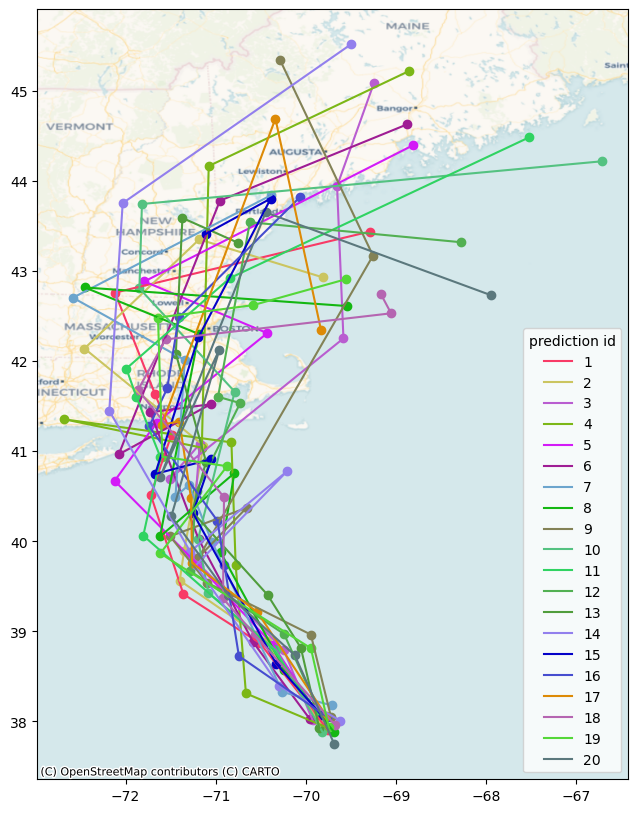

In [62]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for pred_id, pred in forecast.groupby('prediction'):
    c = random_color()
    pred.plot(color=c, ax=ax)
    line_to_plot = LineString(pred.geometry.values)
    ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], color=c, label=f'{pred_id}')
ax.legend(title='prediction id')
ctx.add_basemap(ax,
               crs=forecast.crs,
               source=ctx.providers.CartoDB.Voyager
              )

In [63]:
#put it in meters
forecast_utm = forecast.to_crs(forecast.estimate_utm_crs())
                 
forecast_utm["x"] = forecast_utm.geometry.x
forecast_utm["y"] = forecast_utm.geometry.y

forecast_utm.head()

,prediction,forecastHour,datetime,maxWinds,category,geometry,x,y
0,1,12,2023-08-02 08:00:00,70,1,POINT (433629.56 4195533.402),433629.559834,4.195533e+06
1,1,24,2023-08-02 20:00:00,75,1,POINT (369229.136 4303270.796),369229.136006,4.303271e+06
2,1,36,2023-08-03 08:00:00,85,2,POINT (296941.056 4365278.025),296941.055799,4.365278e+06
3,1,48,2023-08-03 20:00:00,85,2,POINT (269441.75 4488764.971),269441.749791,4.488765e+06
4,1,60,2023-08-04 08:00:00,100,3,POINT (291190.307 4562266.885),291190.307229,4.562267e+06


In [64]:
#centroids
centroid_utm = (forecast_utm
     .groupby('forecastHour', as_index=False)
     [['x','y']]
     .mean()
     .assign(geometry = lambda df : gpd.points_from_xy(x=df.x,y=df.y, crs=forecast_utm.crs ))
    )


centroid_utm.head()

,forecastHour,x,y,geometry
0,12,431013.171246,4.205562e+06,POINT (431013.171 4205562.358)
1,24,383776.795557,4.291724e+06,POINT (383776.796 4291723.649)
2,36,316221.478205,4.399308e+06,POINT (316221.478 4399307.608)
3,48,311348.742931,4.496668e+06,POINT (311348.743 4496668.321)
4,60,297292.489615,4.551259e+06,POINT (297292.49 4551258.648)


In [65]:
#distances between points and centroids
dist_gdf = (forecast_utm
 .merge(centroid_utm[['forecastHour','geometry']], how='left', on='forecastHour', suffixes=['_orig', '_cent'])
 .assign(radius_m = lambda df: df.geometry_orig.distance(df.geometry_cent))
)

dist_gdf

,prediction,forecastHour,datetime,maxWinds,category,geometry_orig,x,y,geometry_cent,radius_m
0,1,12,2023-08-02 08:00:00,70,1,POINT (433629.56 4195533.402),433629.559834,4.195533e+06,POINT (431013.171 4205562.358),10364.625743
1,1,24,2023-08-02 20:00:00,75,1,POINT (369229.136 4303270.796),369229.136006,4.303271e+06,POINT (383776.796 4291723.649),18573.395229
2,1,36,2023-08-03 08:00:00,85,2,POINT (296941.056 4365278.025),296941.055799,4.365278e+06,POINT (316221.478 4399307.608),39111.983164
3,1,48,2023-08-03 20:00:00,85,2,POINT (269441.75 4488764.971),269441.749791,4.488765e+06,POINT (311348.743 4496668.321),42645.738572
4,1,60,2023-08-04 08:00:00,100,3,POINT (291190.307 4562266.885),291190.307229,4.562267e+06,POINT (297292.49 4551258.648),12586.417665
...,...,...,...,...,...,...,...,...,...,...
155,20,48,2023-08-03 20:00:00,85,2,POINT (288048.889 4461358.998),288048.889383,4.461359e+06,POINT (311348.743 4496668.321),42304.036141
156,20,60,2023-08-04 08:00:00,100,3,POINT (338056.994 4665951.053),338056.994238,4.665951e+06,POINT (297292.49 4551258.648),121721.373193
157,20,72,2023-08-04 20:00:00,105,3,POINT (278917.064 4509798.311),278917.063668,4.509798e+06,POINT (297655.504 4625267.632),116979.883803
158,20,96,2023-08-05 20:00:00,90,2,POINT (383428.653 4834184.482),383428.653251,4.834184e+06,POINT (337862.156 4801626.092),56003.164841


In [66]:
radii = dist_gdf.groupby("forecastHour", as_index=False)[["radius_m"]].mean()
radii

,forecastHour,radius_m
0,12,12329.114199
1,24,26541.019450
2,36,32410.237643
3,48,48805.857816
4,60,64245.269275
5,72,79001.952104
6,96,92859.784016
7,120,129567.116892


In [67]:
#.pipe switches the grouped dataframe to a geodataframe
forecast_radius_m_utm = (centroid_utm
                            .merge(radii, on="forecastHour")
                           .pipe(gpd.GeoDataFrame))
forecast_radius_m_utm

,forecastHour,x,y,geometry,radius_m
0,12,431013.171246,4.205562e+06,POINT (431013.171 4205562.358),12329.114199
1,24,383776.795557,4.291724e+06,POINT (383776.796 4291723.649),26541.019450
2,36,316221.478205,4.399308e+06,POINT (316221.478 4399307.608),32410.237643
3,48,311348.742931,4.496668e+06,POINT (311348.743 4496668.321),48805.857816
4,60,297292.489615,4.551259e+06,POINT (297292.49 4551258.648),64245.269275
5,72,297655.503997,4.625268e+06,POINT (297655.504 4625267.632),79001.952104
6,96,337862.155698,4.801626e+06,POINT (337862.156 4801626.092),92859.784016
7,120,477607.910696,4.851970e+06,POINT (477607.911 4851970.224),129567.116892


In [68]:
# fig, ax = plt.subplots(1, 1, figsize=(10,10))

# forecast_circle.plot(ax=ax)

# ctx.add_basemap(ax,
#                crs=forecast_circle.crs,
#                source=ctx.providers.OpenStreetMap.Mapnik
#               )

In [69]:
forecast_circle  = forecast_radius_m_utm.copy()
forecast_circle['geometry'] = forecast_circle.geometry.buffer(forecast_circle.radius_m)
forecast_circle = forecast_circle.drop(columns=["x", "y"])
forecast_circle = forecast_circle.to_crs(epsg=4326)
forecast_circle

,forecastHour,geometry,radius_m
0,12,"POLYGON ((-69.64529 37.99595, -69.64587 37.985...",12329.114199
1,24,"POLYGON ((-70.03234 38.76968, -70.03347 38.746...",26541.019450
2,36,"POLYGON ((-70.76632 39.73023, -70.76741 39.701...",32410.237643
3,48,"POLYGON ((-70.65305 40.60901, -70.65477 40.565...",48805.857816
4,60,"POLYGON ((-70.64885 41.10082, -70.65112 41.044...",64245.269275
5,72,"POLYGON ((-70.48397 41.76967, -70.48693 41.699...",79001.952104
6,96,"POLYGON ((-69.85502 43.3643, -69.85938 43.2823...",92859.784016
7,120,"POLYGON ((-67.6674 43.81303, -67.67768 43.6988...",129567.116892


In [70]:
from shapely.ops import unary_union
polygon_list = forecast_circle.geometry.tolist()
coastline_cone = unary_union(MultiPolygon(polygon_list).convex_hull)
coastline_cone
coastline_cone_gdf = gpd.GeoDataFrame(index=[0], geometry=[coastline_cone], crs='EPSG:4326')
coastline_cone_gdf

,geometry
0,"POLYGON ((-69.78451 37.88399, -69.79826 37.884..."


In [71]:
def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged



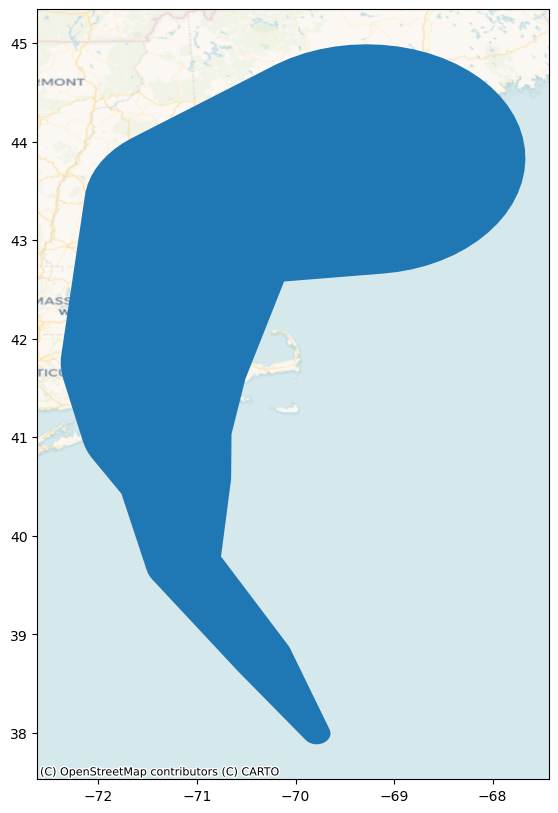

In [72]:
cone = visualizeUncertainty(forecast_circle.to_crs(epsg=4326))
fig, ax = plt.subplots(1, 1, figsize=(10,10))

p = gpd.GeoSeries(cone)
p.plot(ax=ax, )


ctx.add_basemap(ax,
               crs=forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()

In [73]:
def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged

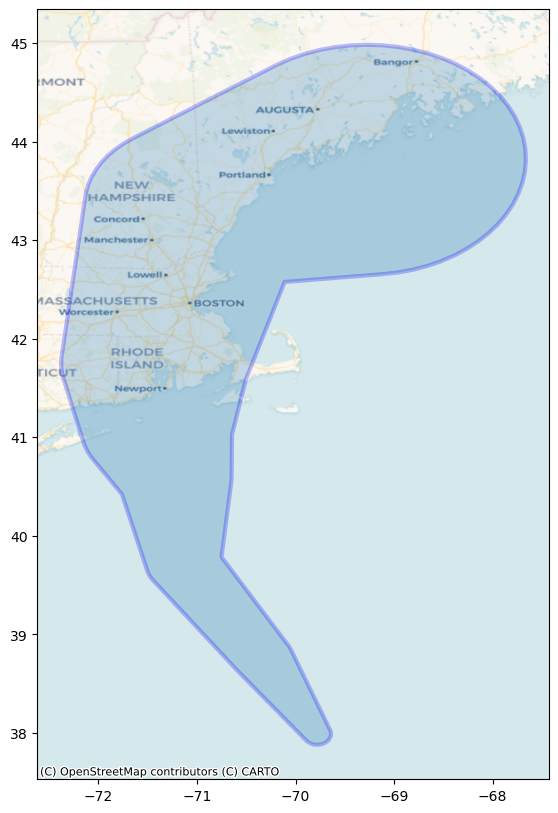

In [74]:
cone = visualizeUncertainty(forecast_circle)
fig, ax = plt.subplots(1, 1, figsize=(10,10))

p = gpd.GeoSeries(cone)
p.plot(ax=ax, alpha= 0.25, edgecolor= "blue", linewidth= 3)


ctx.add_basemap(ax,
               crs=forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()


In [29]:
!pip install shapely geojson

# track shows where the storm actually went in the past
day1_track = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_track_past.geojson')
day1_track.plot()

# Location of Areas of Interest


In [30]:
!wget https://files.bwsi-remote-sensing.net/data/final/R1-Hospitals.zip -O R1-Hospitals.zip
!unzip R1-Hospitals.zip

--2024-08-03 01:01:57--  https://files.bwsi-remote-sensing.net/data/final/R1-Hospitals.zip
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 52.32.177.214, 54.186.10.246, 34.213.124.230, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|52.32.177.214|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-08-03 01:01:57 ERROR 404: Not Found.

Archive:  R1-Hospitals.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of R1-Hospitals.zip or
        R1-Hospitals.zip.zip, and cannot find R1-Hospitals.zip.ZIP, period.


In [31]:
!wget https://files.bwsi-remote-sensing.net/data/final/R1-Shelters.zip -O R1-Shelters.zip
!unzip R1-Shelters.zip

--2024-08-03 01:02:00--  https://files.bwsi-remote-sensing.net/data/final/R1-Shelters.zip
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 34.213.124.230, 54.201.69.220, 52.32.177.214, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|34.213.124.230|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-08-03 01:02:00 ERROR 404: Not Found.

Archive:  R1-Shelters.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of R1-Shelters.zip or
        R1-Shelters.zip.zip, and cannot find R1-Shelters.zip.ZIP, period.


In [32]:
!pip install fiona

In [75]:
import rasterio
import rasterio.plot
import rasterio.merge 
import rasterio.mask
import pyproj
import osmnx as ox
import geopandas as gpd
import pandas as pd
# !pip install fiona
import fiona
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [76]:
# import necessary libraries
import ee
import geemap
ee.Authenticate()
ee.Initialize()

In [77]:
cone_json = shapely.geometry.mapping(cone)
cone_GEE = ee.Feature(cone_json)

In [78]:
#vis params because they take too much space
vis_params = {
    'min': -25,            # Minimum value for color scaling
    'max': 700,        # Maximum value for color scaling
    'palette': ['blue', 'green', 'yellow', 'red']  # Color palette (optional)
}

viz_pop = {
    "min": 0.0,
    "max": 1000.0,
    "palette": ["#f7fcf0", "#e0f3f8", "#bfd3c1", "#f4a582", "#d73027"]
}

viz_svi = {
    "min": 0.0,  
    "max": 1.0,  
    "palette": ['blue', 'green', 'yellow', 'purple']  
}


<Axes: >

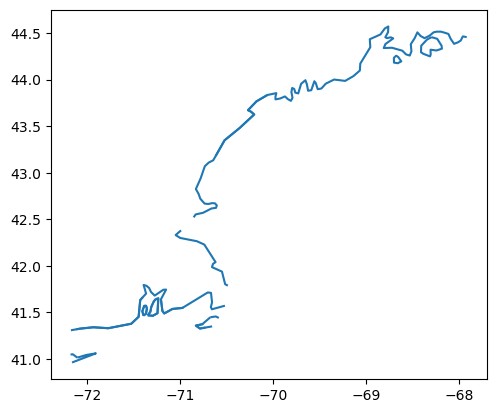

In [79]:
coastline = gpd.read_file("ne_50m_coastline.shp")
#cone_gdf = gpd.GeoDataFrame(index=[0], geometry=[cone], crs=coastline.crs)

# Find the intersection
intersection = gpd.overlay(coastline, forecast_circle, how='intersection')
intersection.plot()
# Save or inspect the result
#intersection.to_file('path_to_intersection_shapefile.shp')

In [56]:
srtm = ee.Image('USGS/SRTMGL1_003') #Load DEM from USGS

coastline = gpd.read_file("ne_50m_coastline.shp") #Load coastline shapefile
coastline.crs = "EPSG:4326"  # Set CRS

coastline_cone_gdf.crs = "EPSG:4326"  # Set CRS

# Find the intersection
intersection = gpd.overlay(coastline, coastline_cone_gdf, how='intersection') #Find intersection between coastline and hurricane path

intersection_gdf = gpd.GeoDataFrame(geometry=intersection.geometry) #Convert geoseries to a GeoDataFrame
intersection_gdf = intersection_gdf.to_crs(epsg=3857) #Convert CRS to meters
intersection_gdf['geometry'] = intersection_gdf['geometry'].buffer(5000) #Add a 5km buffer
intersection_gdf = intersection_gdf.to_crs(epsg=4326) #Convert CRS back to LAT and LON

geometry = intersection_gdf.unary_union #Merge all the unusual geometry to get a clean product

intersection_gdf = gpd.GeoDataFrame(index=[0], geometry=[geometry], crs='EPSG:4326') #Convert geoseries to a GeoDataFrame

ee_coastline = geemap.gdf_to_ee(intersection_gdf) #Convert a GeoDataFrame into a google ee image

forecast_centers = forecast_radius_m_utm.copy().drop(columns=['radius_m']) #Drop the radius_m column, I just didn't like it

#PS: The code below repeats a LOT
#------------------Zone 80---------------------------#
zone_80 = forecast_centers.copy() #Create a copy
zone_80 = zone_80.to_crs(epsg=3857) #Convert CRS to meters
zone_80['geometry'] = zone_80['geometry'].buffer(80 * 1000) #Add an 80km buffer
zone_80 = zone_80.to_crs(epsg=4326) #Convert CRS back to LAT and LON
ee_zone80 = geemap.gdf_to_ee(zone_80) #Convert a GeoDataFrame into a google ee image

intersection_80 = gpd.overlay(intersection_gdf, zone_80, how='intersection') #Find intersection between modified coastline and hurricane path centroids
intersection_80_gdf = gpd.GeoDataFrame(geometry=intersection_80.geometry) #Convert geoseries to a GeoDataFrame
ee_intersection_80 = geemap.gdf_to_ee(intersection_80_gdf) #Convert a GeoDataFrame into a google ee image
#------------------Zone 160---------------------------#
zone_160 = forecast_centers.copy()
zone_160 = zone_160.to_crs(epsg=3857)
zone_160['geometry'] = zone_160['geometry'].buffer(160 * 1000)
zone_160 = zone_160.to_crs(epsg=4326)
ee_zone160 = geemap.gdf_to_ee(zone_160)

intersection_160 = gpd.overlay(intersection_gdf, zone_160, how='intersection')
intersection_160_gdf = gpd.GeoDataFrame(geometry=intersection_160.geometry)
ee_intersection_160 = geemap.gdf_to_ee(intersection_160_gdf)
#------------------Zone 300---------------------------#
zone_300 = forecast_centers.copy()
zone_300 = zone_300.to_crs(epsg=3857)
zone_300['geometry'] = zone_300['geometry'].buffer(300 * 1000)
zone_300 = zone_300.to_crs(epsg=4326)
ee_zone300 = geemap.gdf_to_ee(zone_300)


intersection_300 = gpd.overlay(intersection_gdf, zone_300, how='intersection')
intersection_300_gdf = gpd.GeoDataFrame(geometry=intersection_300.geometry)
ee_intersection_300 = geemap.gdf_to_ee(intersection_300_gdf)

#---------Adding layers and masks to google map-----------#
srtm = srtm.updateMask(srtm.gt(0)) #Remove the ocean and areas with an elevation less than or equal to 0
srtm_masked_6 = srtm.updateMask(srtm.lt(6)).clip(ee_intersection_80) #Get areas under 6 meters of elevation
srtm_masked_4 = srtm.updateMask(srtm.lt(4)).clip(ee_intersection_160) #Get areas under 4 meters of elevation
srtm_masked_3 = srtm.updateMask(srtm.lt(3)).clip(ee_intersection_300) #Get areas under 3 meters of elevation

Map = geemap.Map() #Initialize a map

Map.addLayer(srtm_masked_3, {
    'min': -25,      
    'max': 700,
    'palette': ['#bb00c7']
}, 'DEM_updated3')
Map.addLayer(srtm_masked_4, {
    'min': -25,      
    'max': 700,
    'palette': ['#011f4b']
}, 'DEM_updated4')
Map.addLayer(srtm_masked_6, {
    'min': -25,      
    'max': 700,
    'palette': ['00FFFF']
}, 'DEM_updated6')

#Map.addLayer(ee_coastline, {}, "coastline")
Map.addLayer(cone_GEE, {}, 'Polygon')
#Map.addLayer(ee_zone300, {}, 'zone300')
#Map.addLayer(ee_zone160, {}, 'zone160')
#Map.addLayer(ee_zone80, {}, 'zone80')
#Map.addLayer(ee_intersection_300, {}, 'inter300')
#Map.addLayer(ee_intersection_160, {}, 'inter160')
#Map.addLayer(ee_intersection_80, {}, 'inter80')
Map.centerObject(cone_GEE, 10)

Map

Map(center=[43.3512621901889, -68.51662866780617], controls=(WidgetControl(options=['position', 'transparent_b…